In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## EDA

In [2]:
# The data dictionary (compiled in MS Excel while going through the data cleaning process) will be imported below so as to ease the process of filtering columns for EDA.

data_dict = pd.read_csv("../datasets/data_dictionary.csv")
data_dict.head(10)

,Column name,Variable type,Col dtype (initial),Col dtype (converted to),Col dtype (final),Needs one-hot encoding,Possible unique values,Unique values in train,Rows of missing data,Description
0,Id,discrete,float,NaN,float,no,NaN,NaN,0,Observation number.
1,PID,nominal,float,NaN,float,no,NaN,NaN,0,Parcel identification number.
2,MS SubClass,nominal,float,NaN,float,yes,16.0,16.0,0,Identifies the type of dwelling involved in th...
3,MS Zoning,nominal,object,NaN,object,yes,8.0,7.0,0,Identifies the general zoning classification o...
4,Lot Frontage,continuous,float,NaN,float,no,NaN,NaN,330,Linear feet of street connected to property.
5,Lot Area,continuous,float,NaN,float,no,NaN,NaN,0,Lot size in square feet.
6,Street,nominal,object,NaN,object,yes,2.0,2.0,0,Type of road access to property.
7,Alley,nominal,object,NaN,object,yes,3.0,3.0,0,Type of alley access to property.
8,Lot Shape,ordinal,object,float,float,no,4.0,4.0,0,"General shape of property. 'Reg' = 4, 'IR1' = ..."
9,Land Contour,nominal,object,NaN,object,yes,4.0,4.0,0,Flatness of the property.


In [3]:
# Read train_cleaned.csv and assign it to a dataframe 'c_train'.
# keep_default_na=False because train_claned.csv has a few object columns which have 'NA' values which have meanings.
# We need to avoid these 'NA' values from being wrongly read as empty NaN values by default.
# Only missing values (blank in the CSV file) should be identified as NaN values.

c_train = pd.read_csv('../datasets/train_cleaned.csv', keep_default_na=False)

In [4]:
c_train.shape

(2044, 81)

In [5]:
# Similar to what was done during the data cleaning process, notice that some columns have wrong data type object, instead of int/float.
# Also, reading the CSV file with keep_default_na=False doesn't give us ANY NaN (null/missing) values in the entire dataframe.

# This is because it reads the missing values in the CSV as '' (empty string) instead.
# This means that some columns with int/float types get converted to object type if they have any missing values.
# So, we need to replace all '' with np.nan in all the numerical columns, and convert remaining values to type float.
# And we need to replace all '' with np.nan in all non-numerical columns.

c_train.dtypes.value_counts()

float64    58
object     23
dtype: int64

In [6]:
# For example, 'Lot Frontage' column should be of type float, but because of the missing values ( read as empty string ''), it is now of type object.

c_train['Lot Frontage'].dtype

dtype('O')

In [7]:
# Filtering columns from data_dict which do not require one-hot encoding. These columns should be of type float.

len(data_dict[data_dict['Needs one-hot encoding']=='no']['Column name'])

60

In [8]:
# Mapping a lambda function for all above filtered numerical columns to convert all '' (empty string) to NaN and all other values to type float.

for col in data_dict[data_dict['Needs one-hot encoding']=='no']['Column name']:
    c_train[col] = c_train[col].map(lambda x : np.nan if x=='' else float(x))

In [9]:
c_train.dtypes.value_counts()

float64    61
object     20
dtype: int64

In [10]:
# Verifying correct number of columns with type float and object in c_train dataframe.

data_dict['Col dtype (final)'].value_counts()

float     61
object    20
Name: Col dtype (final), dtype: int64

In [11]:
# Re-checking type of 'Lot Frontage' column to ensure it is now of correct type float.

c_train['Lot Frontage'].dtype

dtype('float64')

In [12]:
# Mapping a lambda function for all non-numerical columns to convert all '' (empty string) to NaN.

for col in c_train.columns:
    if col not in data_dict[data_dict['Needs one-hot encoding']=='no']['Column name']:
        c_train[col] = c_train[col].map(lambda x : np.nan if x=='' else x)

In [13]:
# Checking for all np.nan values in all columns and filtering out columns which have one or more rows with np.nan values.
# This is the number of remaining missing values in the dataframe.
# I will consider imputing this missing data if these columns are absolutely required in the regression model.

null_cols_c_train = c_train.isna().sum()[c_train.isna().sum()!=0]
null_cols_c_train

Lot Frontage     330
Mas Vnr Type      22
Mas Vnr Area      22
Garage Yr Blt    113
dtype: int64

In [14]:
# Reading train_cleaned_encoded.csv and assigning it to a new dataframe 'ce_train'.

ce_train = pd.read_csv('../datasets/train_cleaned_encoded.csv')

In [15]:
ce_train.shape

(2044, 213)

In [16]:
ce_train.dtypes.value_counts()

int64      153
float64     60
dtype: int64

In [17]:
# Checking for all np.nan values in all columns and filtering out columns which have one or more rows with np.nan values.
# This is the number of remaining missing values in the dataframe.
# I will consider imputing this missing data if these columns are absolutely required in the regression model.

null_cols_ce_train = ce_train.isna().sum()[ce_train.isna().sum()!=0]
null_cols_ce_train

# The above c_train dataframe has 22 missing values (NaN) in 'Mas Vnr Type' column, but ce_train does not have any missing values in this.
# This is because 'Mas Vnr Type' column was one-hot encoded and the 22 rows with missing values were ignored (dummy_na=False in pd.get_dummies()),
# since the number of rows with missing values (22) is only about 1% of the total number of rows.

Lot Frontage     330
Mas Vnr Area      22
Garage Yr Blt    113
dtype: int64

## WRITE THIS PROPERLY

Now that I have train.csv cleaned (train_cleaned.csv imported as *'c_train'*) and one-hot encoded (train_cleaned_encoded.csv imported as *'ce_train'*), I can start the Exploratory Data Analysis (EDA) process.

The following 2 columns will be disregarded from this point on because of the reasons explained below:

- **Id**: Type *int*, discrete. Shows observation number. Wouldn't make logical sense to include it in the regression model.
- **PID**: Type *int*, nominal. Shows parcel identification number. Wouldn't make logical sense to include it in the regression model.

I will now go through the EDA process with different types of variables (continuous, discrete, ordinal & nominal), one at a time. For each type, I will examine the variables and determine which of these should be included in the next stage of feature selection for regression modelling. This needs to be done in order to make the dataset more manageable in terms of variables available (currently we have >200 columns of variables) and to determine the presence of any outliers, etc. Once I obtain a more manageable number of features, I will then employ different techniques of feature selection and evaluate models built using them.

One of the assumptions for multiple linear regression (MLR) is that of **linearity** - *target variable Y must have an approximately linear relationship with each independent predictor X*. To determine this relationship, we will utilize the Pearson/Spearman/Kendall correlation coefficients. The choice between Pearson, Spearman and Kendall depends on the distribution of the variable (normal vs. not normal) and the type of variable (continuous vs. discrete/ordinal).

### EDA for Continuous Variables

In [18]:
# Filtering all columns of continuous variables.
# These columns will be used to calculate the correlation coefficient against 'SalePrice' column.

continuous_corr_df = pd.DataFrame(data_dict.loc[data_dict['Variable type']=='continuous', 'Column name'])

#Creating an extra column 'SalePrice' of 0 values. These values will be replaced with the correlation coefficient.
continuous_corr_df['SalePrice'] = 0

# Setting 'Column name' column as index.
continuous_corr_df.set_index('Column name', inplace=True)

# Transposing the dataframe to make indices into columns.
continuous_corr_df = continuous_corr_df.T

# Dropping the 'SalePrice' column (because we don't need to see the correlation between 'SalePrice' and 'SalePrice')
continuous_corr_df.drop(columns=['SalePrice'], inplace=True)

continuous_corr_df

Column name,Lot Frontage,Lot Area,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val
SalePrice,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


To determine which correlation method should be used for continuous variables, I will have to first determine the distribution of each variable itself. According to this [page](https://www.statisticssolutions.com/correlation-pearson-kendall-spearman/), one of the assumptions for Pearson correlation is that the variables should be normally distributed. So, if the continuous variable is normally distributed, Pearson correlation will be used. If it is not normally distributed, Kendall correlation will be utilized. According to this [page](https://towardsdatascience.com/kendall-rank-correlation-explained-dee01d99c535), "*Kendall rank correlation (non-parametric) is an alternative to Pearson’s correlation (parametric) when the data you’re working with has failed one or more assumptions of the test*."

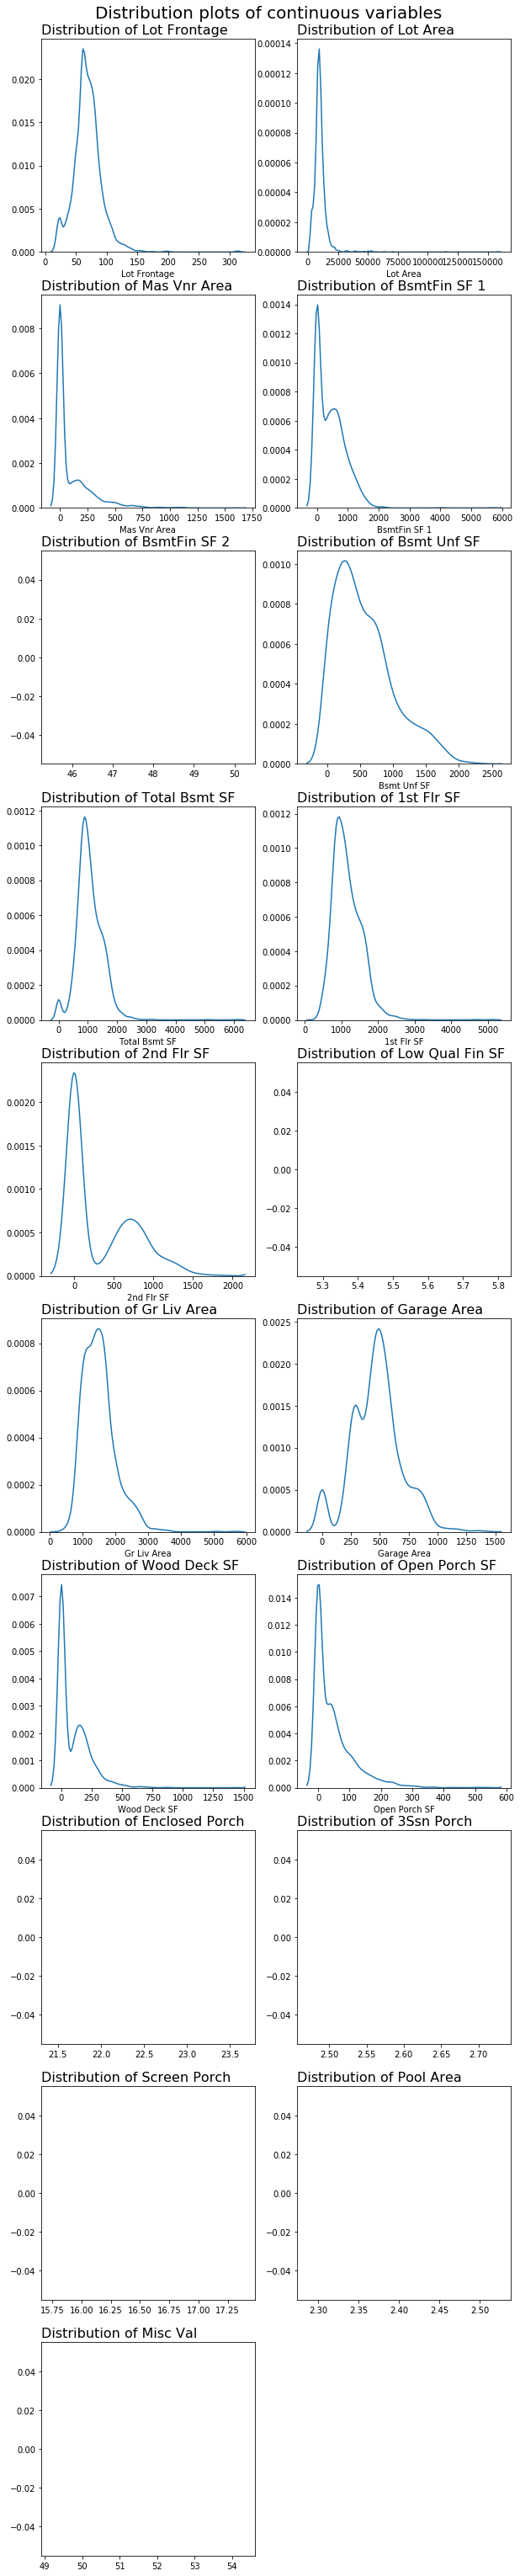

In [19]:
# Plotting distribution plots of all continuous variables.

fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(10,55))

ax = ax.ravel()

for i, col in enumerate(list(continuous_corr_df.columns)):
    
    ax[i].set_title(f"Distribution of {col}", fontsize=16, loc='left')
    
    # We use try & except because some variables are not normally distributed and throw this error during kde calculation:
    # "RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density." 
    try:
        sns.distplot(ce_train[col], ax=ax[i], hist=False, kde=True)
    except:
        pass
    
ax[19].remove()

fig.suptitle(x=0.5, y=0.893, t="Distribution plots of continuous variables", fontsize=20)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/distplots_continuous_variables.png', bbox_inches='tight')

From the above distribution plots, we see that **none of the continuous variables are normally distributed**. Hence, I will use the **Kendall correlation method** to determine the correlation between 'SalePrice' and continuous variables (instead of the Pearson correlation method).

In [20]:
# Finding the Kendall correlation coefficient for all continuous variable columns.

for col in continuous_corr_df.columns:
    kendall_coef = ce_train[['SalePrice', col]].corr(method='kendall').iloc[0,1]
    continuous_corr_df.loc['SalePrice', col] = kendall_coef

continuous_corr_df

Column name,Lot Frontage,Lot Area,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val
SalePrice,0.281687,0.296508,0.349073,0.255441,-0.030541,0.109745,0.448052,0.424598,0.185217,-0.069536,0.539097,0.488316,0.269858,0.357655,-0.177954,0.047482,0.085878,0.028669,-0.025752


In [21]:
# Sorting values of correlation coefficients

continuous_corr_df.sort_values(by='SalePrice', axis=1, inplace=True)
continuous_corr_df

Column name,Enclosed Porch,Low Qual Fin SF,BsmtFin SF 2,Misc Val,Pool Area,3Ssn Porch,Screen Porch,Bsmt Unf SF,2nd Flr SF,BsmtFin SF 1,Wood Deck SF,Lot Frontage,Lot Area,Mas Vnr Area,Open Porch SF,1st Flr SF,Total Bsmt SF,Garage Area,Gr Liv Area
SalePrice,-0.177954,-0.069536,-0.030541,-0.025752,0.028669,0.047482,0.085878,0.109745,0.185217,0.255441,0.269858,0.281687,0.296508,0.349073,0.357655,0.424598,0.448052,0.488316,0.539097


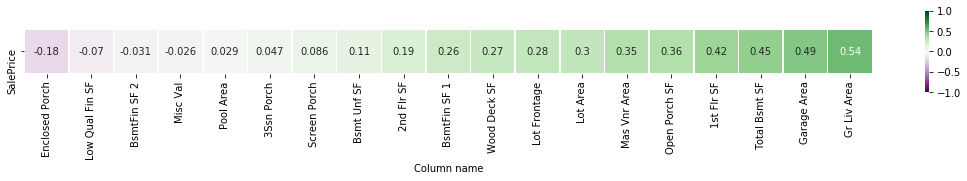

In [22]:
# Plotting the above in a heatmap to visualize the relationship.

plt.figure(figsize=(19,1.5))

sns.heatmap(continuous_corr_df, vmin=-1, vmax=1, annot=True, square=True, linewidths=0.5, cmap='PRGn')

# Exporting plot image in PNG format.
plt.savefig('../plot_images/heatmap_continuous_variables.png', bbox_inches='tight')

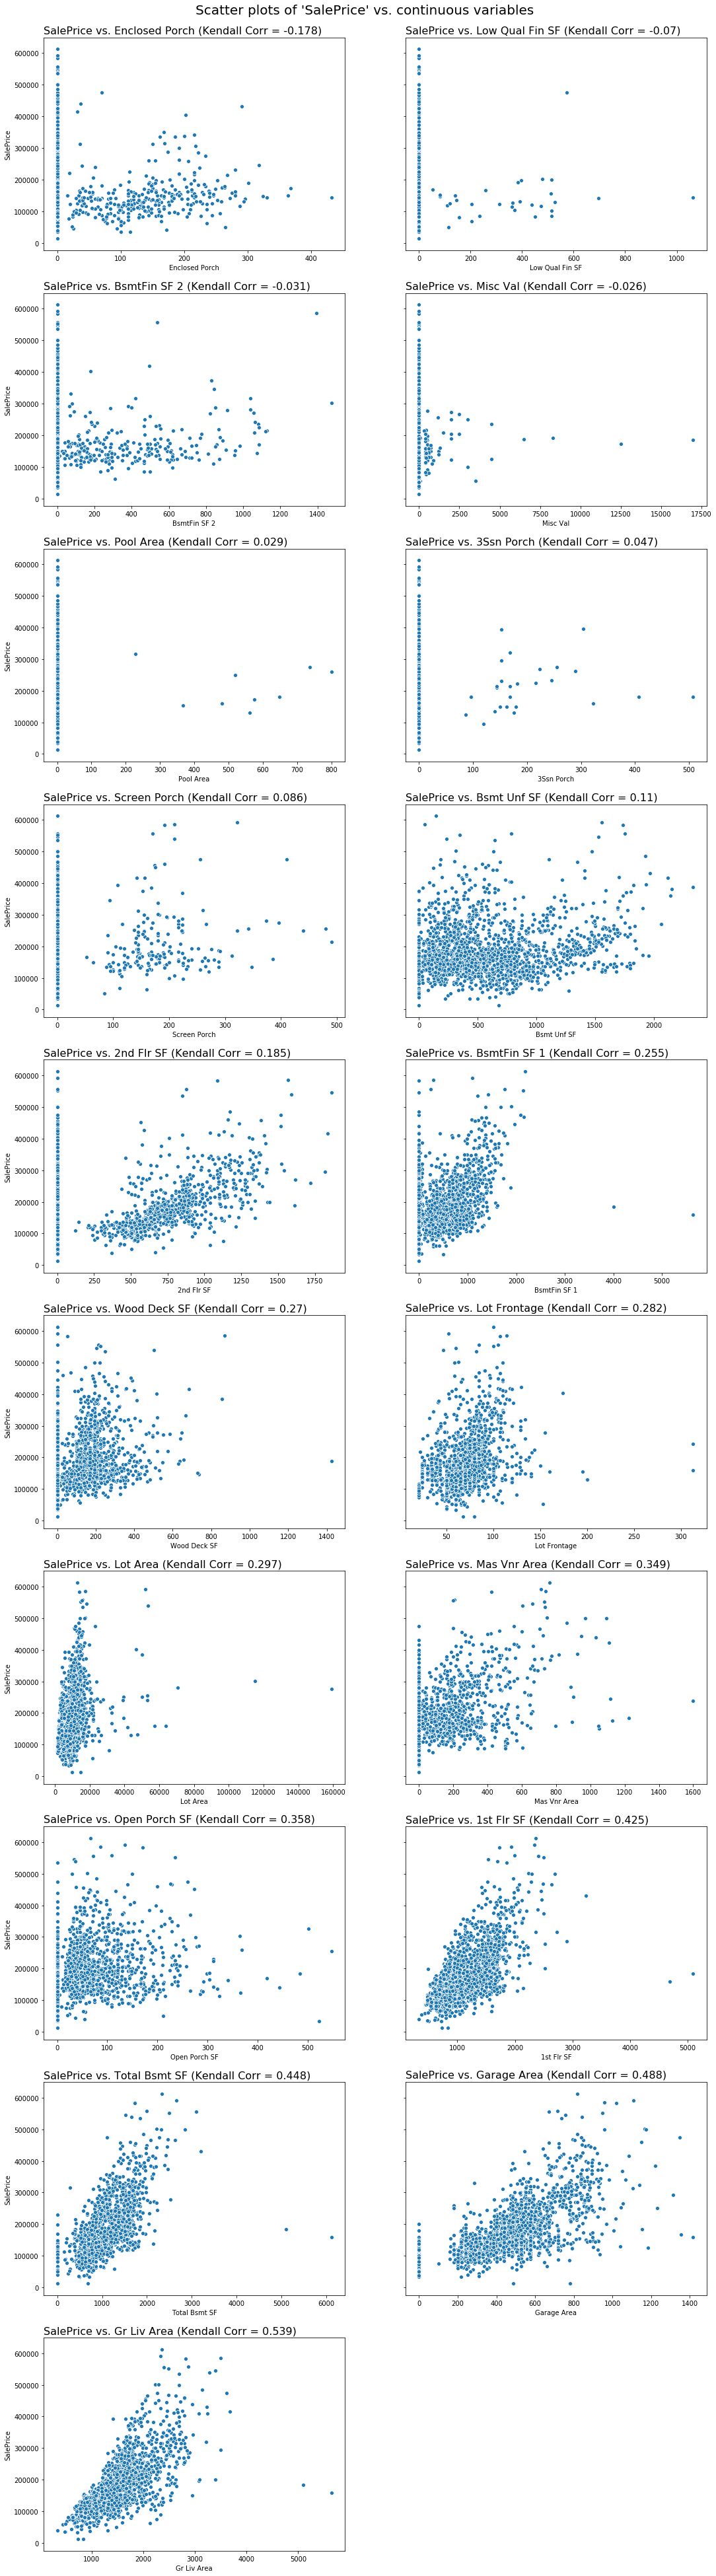

In [23]:
fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(18,70), sharey=True)

ax = ax.ravel()

for i, col in enumerate(list(continuous_corr_df.columns)):
    
    sns.scatterplot(data=ce_train, x=col, y='SalePrice', ax=ax[i])
    
    kendall_coef = str(round(ce_train[['SalePrice', col]].corr(method='kendall').iloc[0,1], 3))
    
    ax[i].set_title(f"SalePrice vs. {col} (Kendall Corr = {kendall_coef})", fontsize=16, loc='left')

ax[19].remove()
fig.suptitle(x=0.5, y=0.89, t="Scatter plots of 'SalePrice' vs. continuous variables", fontsize=20)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/scatterplots_continuous_variables.png', bbox_inches='tight')

From the above heatmap and scatter plots, we deduce the following about continuous variables:

- **Outliers**: Some columns, such as *'BsmtFin SF 1', 'Wood Deck SF', 'Lot Frontage', 'Lot Area', '1st Flr SF', 'Total Bsmt SF' & 'Gr Liv Area'*, have 1-2 outliers. These should be removed before proceeding, so as to ensure they have a better linear relationship with 'SalePrice', and the model built using these variables does not have a high bias.
- **Variables selected for next stage**: From the heatmap, I will select variables which have Kendall correlation coefficient of <= -0.2 & >= 0.2. So, the columns selected from this stage are: *'BsmtFin SF 1', 'Wood Deck SF', 'Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'Open Porch SF', '1st Flr SF', 'Total Bsmt SF', 'Garage Area' & 'Gr Liv Area'*.

In [54]:
# Filtering all selected variables for next stage.

continuous_selected_list = list(continuous_corr_df.T[(continuous_corr_df.T['SalePrice'] >= 0.2) | (continuous_corr_df.T['SalePrice'] <= -0.2)].index)
continuous_selected_list

['BsmtFin SF 1',
 'Wood Deck SF',
 'Lot Frontage',
 'Lot Area',
 'Mas Vnr Area',
 'Open Porch SF',
 '1st Flr SF',
 'Total Bsmt SF',
 'Garage Area',
 'Gr Liv Area']

In [24]:
# Filtering rows of outliers

# Creating masks for outliers
outlier_mask1 = ce_train['BsmtFin SF 1']>3000
outlier_mask2 = ce_train['Wood Deck SF']>1200
outlier_mask3 = ce_train['Lot Frontage']>250
outlier_mask4 = ce_train['Lot Area']>100_000
outlier_mask5 = ce_train['1st Flr SF']>4000
outlier_mask6 = ce_train['Total Bsmt SF']>4000
outlier_mask7 = ce_train['Gr Liv Area']>4000

outliers_continuous = ce_train[(outlier_mask1) | (outlier_mask2) | (outlier_mask3) | (outlier_mask4) | (outlier_mask5) | (outlier_mask6) | (outlier_mask7)]
outliers_continuous

,Id,PID,Lot Frontage,Lot Area,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Year Built,...,Misc Feature_Shed,Misc Feature_TenC,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
471,2116.0,906426060.0,NaN,159000.0,2.0,4.0,1.0,6.0,7.0,1958.0,...,1,0,0,0,0,0,0,0,0,1
693,2072.0,905301050.0,NaN,115149.0,2.0,4.0,1.0,7.0,5.0,1971.0,...,0,0,0,0,0,0,0,0,0,1
959,1499.0,908154235.0,313.0,63887.0,1.0,4.0,3.0,10.0,5.0,2008.0,...,0,0,0,0,0,0,0,1,0,0
965,2294.0,923229100.0,NaN,15957.0,3.0,4.0,2.0,6.0,6.0,1977.0,...,0,0,0,0,0,0,0,0,0,1
1332,1266.0,535427070.0,313.0,27650.0,2.0,4.0,2.0,7.0,7.0,1960.0,...,0,0,0,0,0,0,0,0,0,1
1879,2181.0,908154195.0,128.0,39290.0,3.0,4.0,3.0,10.0,5.0,2008.0,...,0,0,0,0,0,0,0,1,0,0


In [25]:
# Dropping the above 6 rows of outliers from ce_train dataframe.

ce_train.drop(index=outliers_continuous.index, inplace=True)
ce_train.shape

(2038, 213)

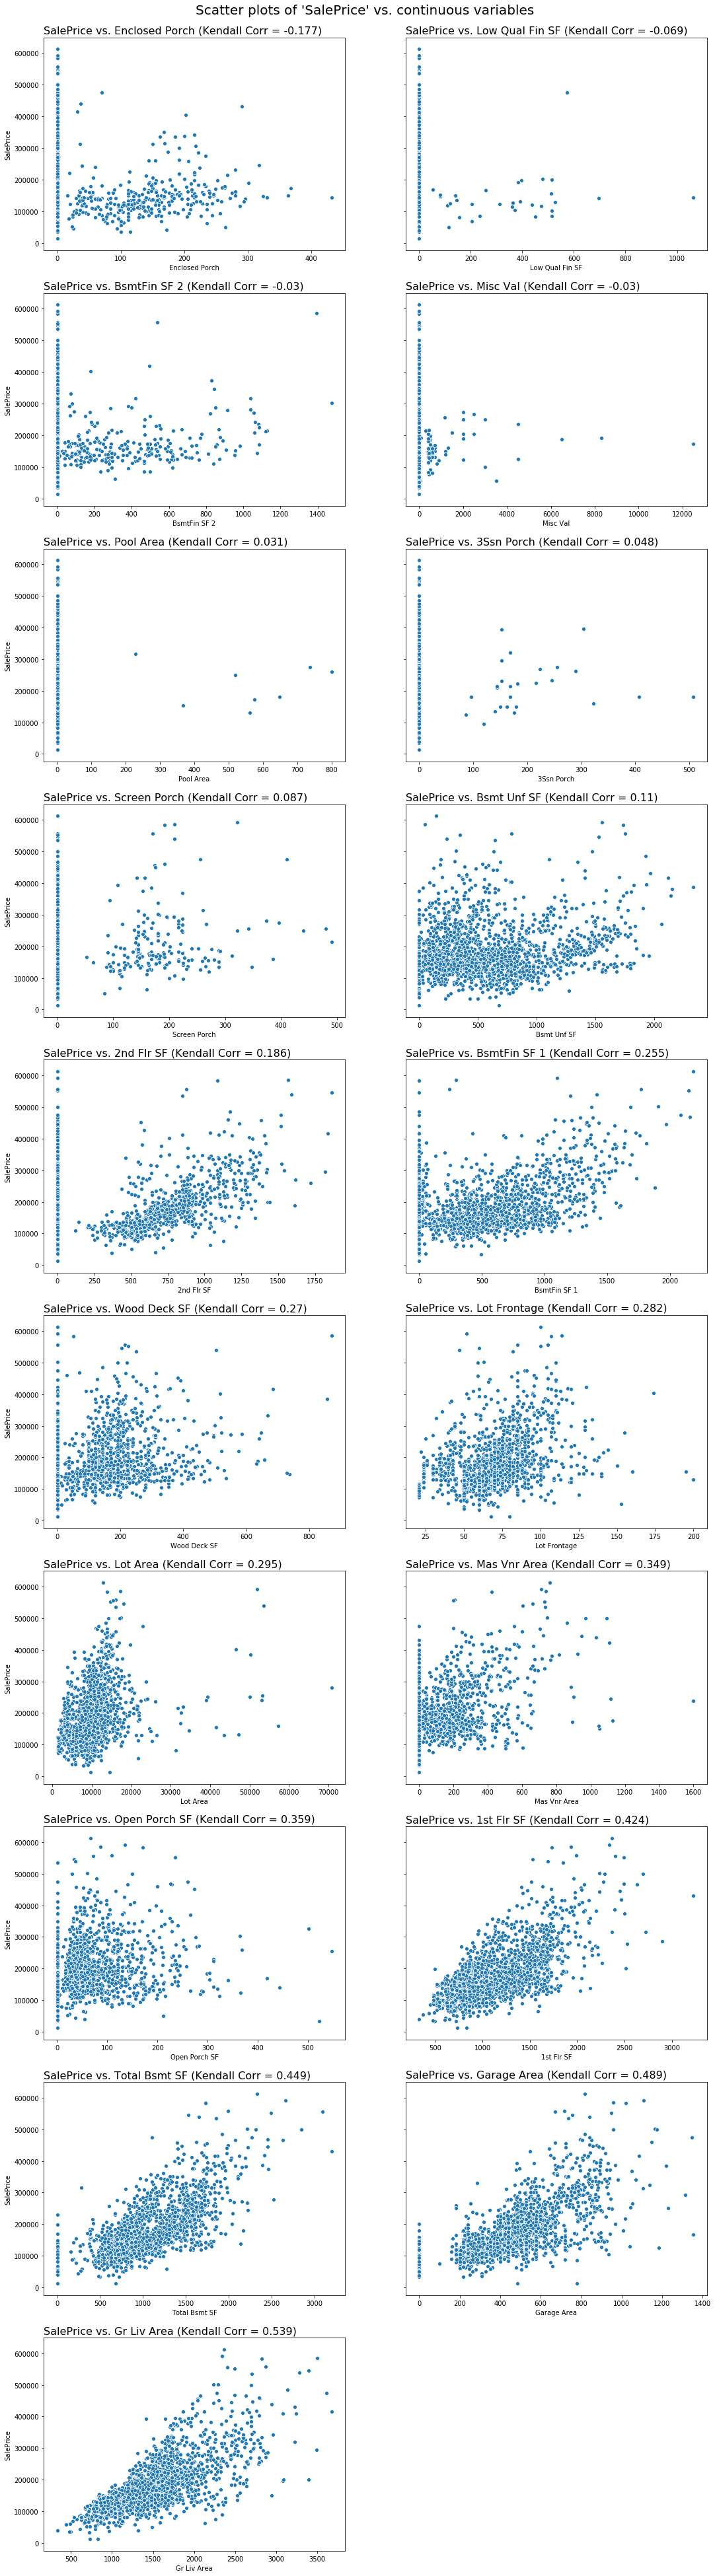

In [26]:
# Plotting the scatter plots again.

fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(18,70), sharey=True)

ax = ax.ravel()

for i, col in enumerate(list(continuous_corr_df.columns)):
    
    sns.scatterplot(data=ce_train, x=col, y='SalePrice', ax=ax[i])
    
    kendall_coef = str(round(ce_train[['SalePrice', col]].corr(method='kendall').iloc[0,1], 3))
    
    ax[i].set_title(f"SalePrice vs. {col} (Kendall Corr = {kendall_coef})", fontsize=16, loc='left')

ax[19].remove()
fig.suptitle(x=0.5, y=0.89, t="Scatter plots of 'SalePrice' vs. continuous variables", fontsize=20)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/scatterplots_continuous_variables_wo_outliers.png', bbox_inches='tight')

### EDA for Discrete Variables

In [37]:
# Filtering all columns of discrete variables.
# These columns will be used to calculate the correlation coefficient against 'SalePrice' column.

discrete_corr_df = pd.DataFrame(data_dict.loc[data_dict['Variable type']=='discrete', 'Column name'])

#Creating an extra column 'SalePrice' of 0 values. These values will be replaced with the correlation coefficient.
discrete_corr_df['SalePrice'] = 0

# Setting 'Column name' column as index.
discrete_corr_df.set_index('Column name', inplace=True)

# Transposing the dataframe to make indices into columns.
discrete_corr_df = discrete_corr_df.T

# Dropping the 'Id' column (As explained above, 'Id' column shows observation number. So, it wouldn't make logical sense to include it in the regression model.)
discrete_corr_df.drop(columns=['Id'], inplace=True)

discrete_corr_df

Column name,Year Built,Year Remod/Add,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Mo Sold,Yr Sold
SalePrice,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Similar to continuous variables above, to determine which correlation method should be used for discrete variables, I will have to first determine the distribution of each variable itself. According to this [page](https://www.statisticssolutions.com/correlation-pearson-kendall-spearman/), one of the assumptions for Pearson correlation is that the variables should be normally distributed. So, if the discrete variable is normally distributed, Pearson correlation will be used. If it is not normally distributed, Kendall correlation will be utilized. According to this [page](https://towardsdatascience.com/kendall-rank-correlation-explained-dee01d99c535), "*Kendall rank correlation (non-parametric) is an alternative to Pearson’s correlation (parametric) when the data you’re working with has failed one or more assumptions of the test*."

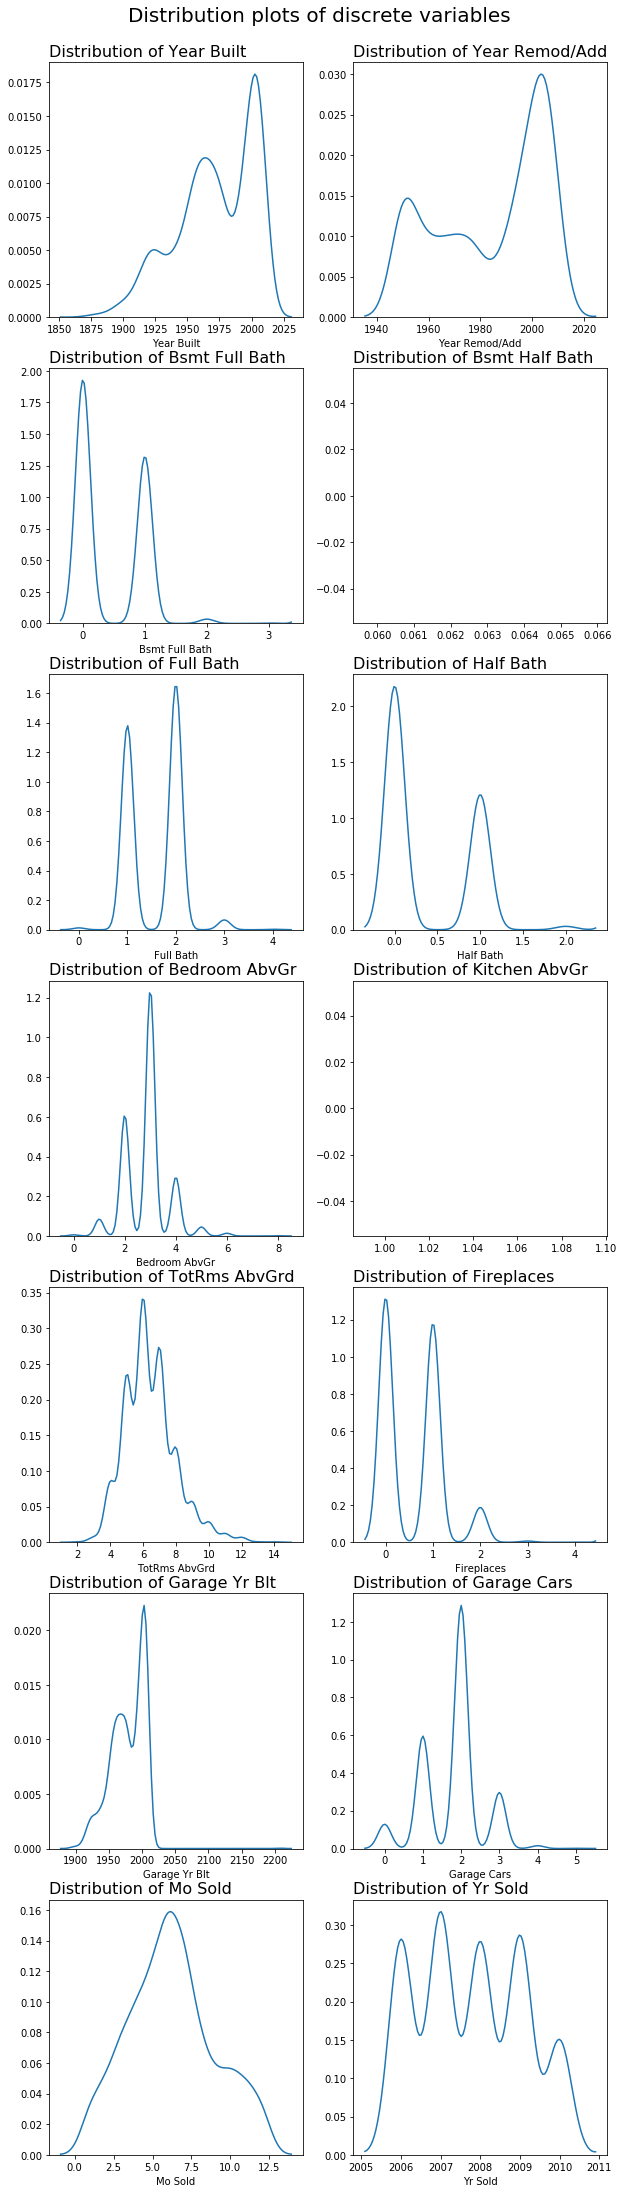

In [35]:
# Plotting distribution plots of all discrete & ordinal variables.

fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(10,38.5))

ax = ax.ravel()

for i, col in enumerate(list(discrete_corr_df.columns)):
    
    ax[i].set_title(f"Distribution of {col}", fontsize=16, loc='left')
    
    # We use try & except because some variables are not normally distributed and throw this error during kde calculation:
    # "RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density." 
    try:
        sns.distplot(ce_train[col], ax=ax[i], hist=False, kde=True)
    except:
        pass

fig.suptitle(x=0.5, y=0.9, t="Distribution plots of discrete variables", fontsize=20)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/distplots_discrete_variables.png', bbox_inches='tight')

From the above distribution plots, we see that **none of the discrete variables are normally distributed**. Hence, I will use the **Kendall correlation method** to determine the correlation between 'SalePrice' and discrete variables (instead of the Pearson correlation method).

In [38]:
# Finding the Kendall correlation coefficient for all discrete variable columns.

for col in discrete_corr_df.columns:
    kendall_coef = ce_train[['SalePrice', col]].corr(method='kendall').iloc[0,1]
    discrete_corr_df.loc['SalePrice', col] = kendall_coef

discrete_corr_df

Column name,Year Built,Year Remod/Add,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Mo Sold,Yr Sold
SalePrice,0.500042,0.447749,0.22223,-0.028739,0.508206,0.268814,0.14783,-0.122376,0.388082,0.417436,0.457047,0.578326,0.027837,-0.005988


In [39]:
# Sorting values of correlation coefficients

discrete_corr_df.sort_values(by='SalePrice', axis=1, inplace=True)
discrete_corr_df

Column name,Kitchen AbvGr,Bsmt Half Bath,Yr Sold,Mo Sold,Bedroom AbvGr,Bsmt Full Bath,Half Bath,TotRms AbvGrd,Fireplaces,Year Remod/Add,Garage Yr Blt,Year Built,Full Bath,Garage Cars
SalePrice,-0.122376,-0.028739,-0.005988,0.027837,0.14783,0.22223,0.268814,0.388082,0.417436,0.447749,0.457047,0.500042,0.508206,0.578326


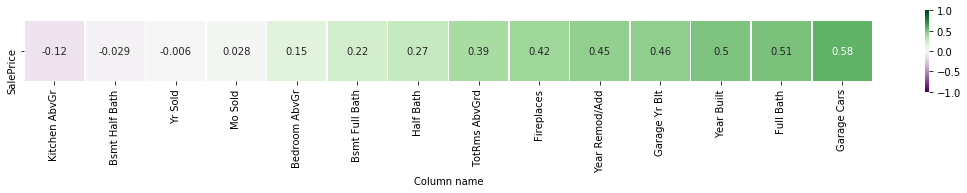

In [40]:
# Plotting the above in a heatmap to visualize the relationship.

plt.figure(figsize=(19,1.5))

sns.heatmap(discrete_corr_df, vmin=-1, vmax=1, annot=True, square=True, linewidths=0.5, cmap='PRGn')

# Exporting plot image in PNG format.
plt.savefig('../plot_images/heatmap_discrete_variables.png', bbox_inches='tight')

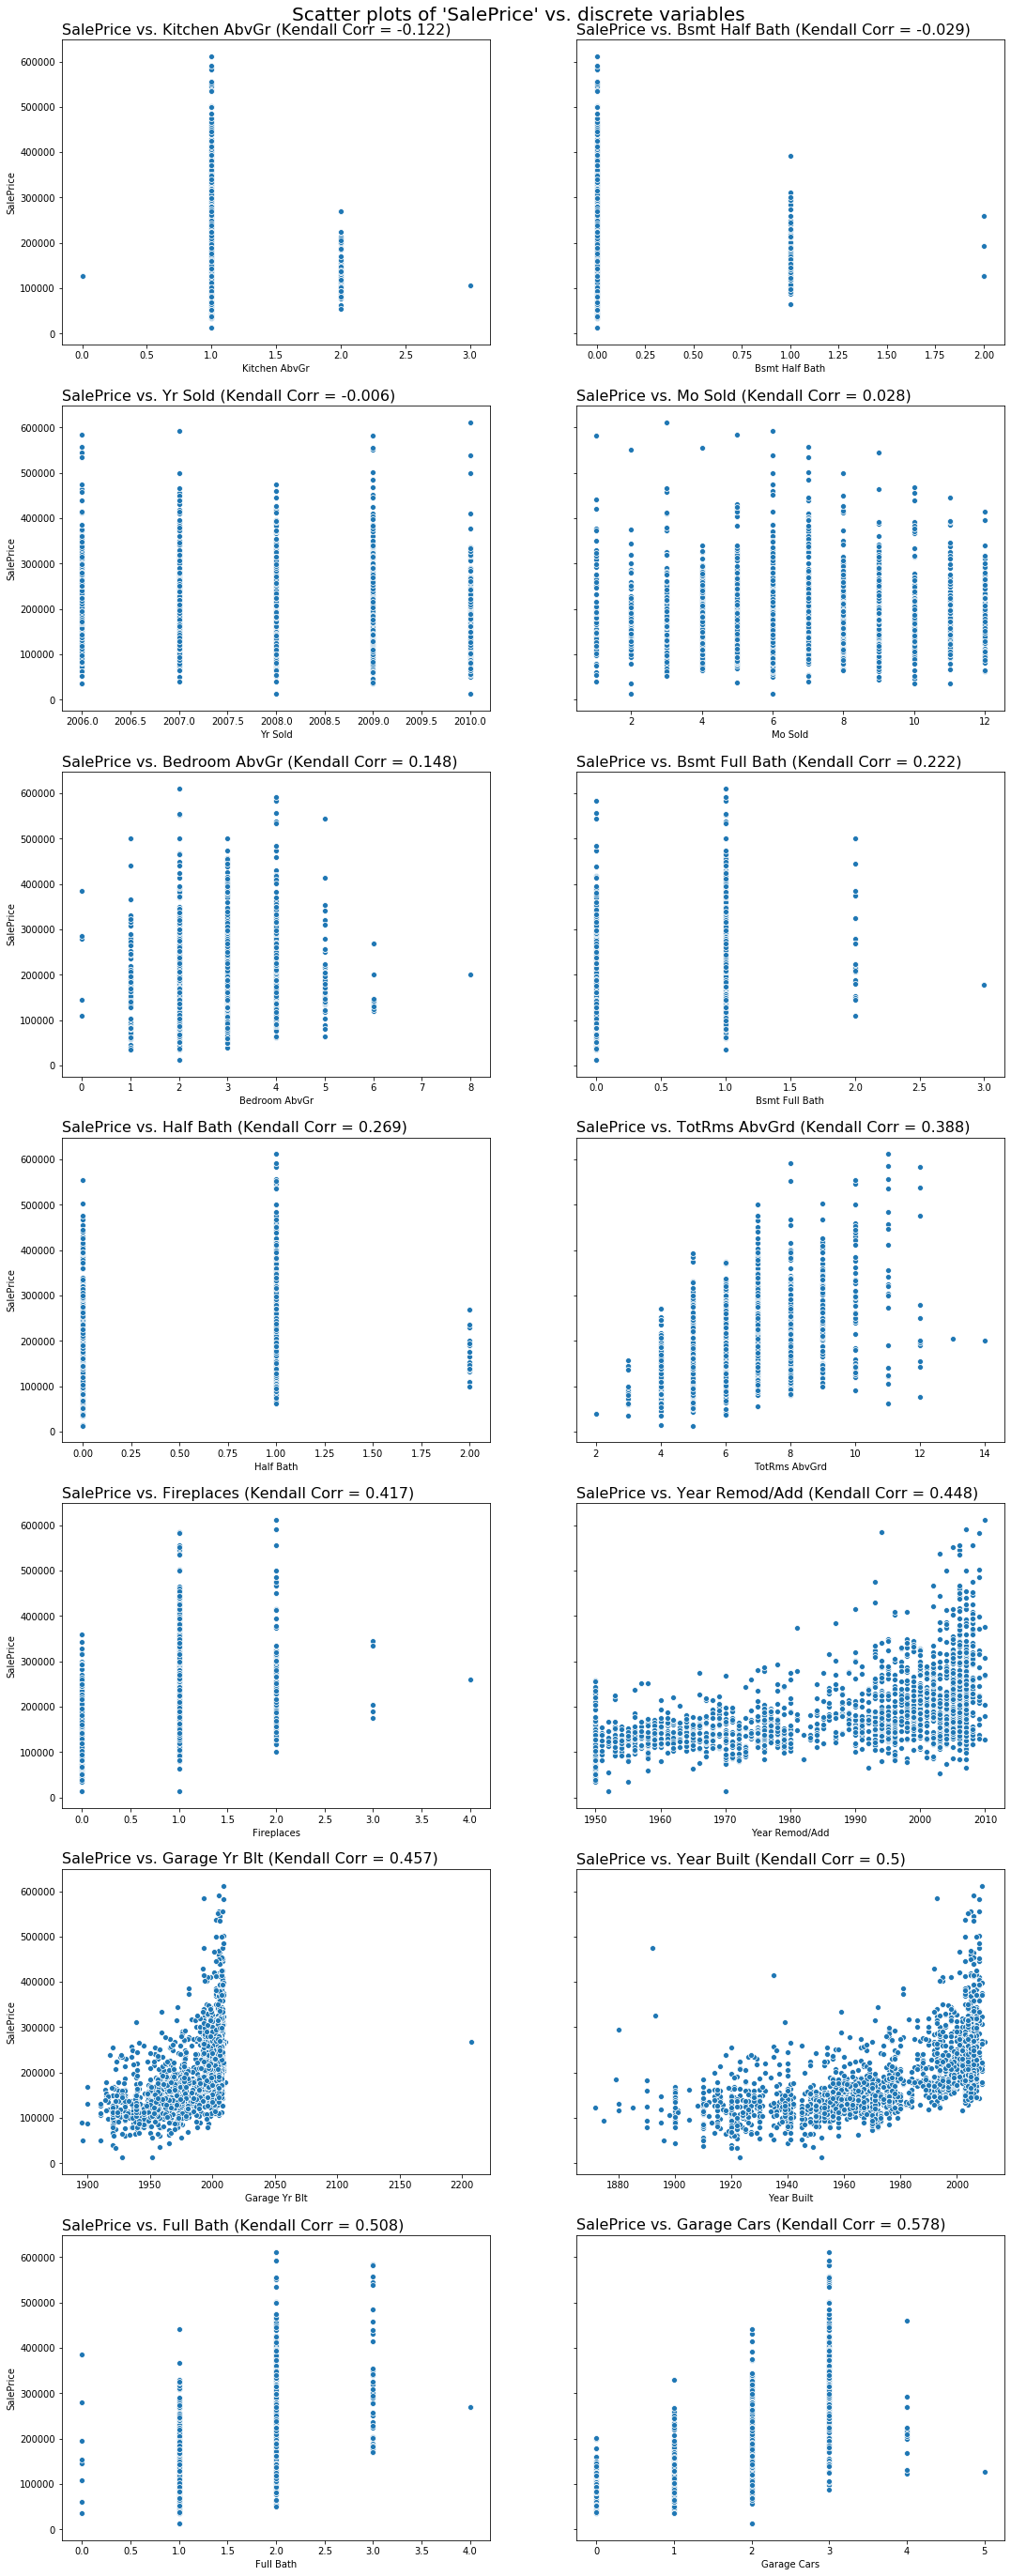

In [41]:
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(18,49), sharey=True)

ax = ax.ravel()

for i, col in enumerate(list(discrete_corr_df.columns)):
    
    sns.scatterplot(data=ce_train, x=col, y='SalePrice', ax=ax[i])
    
    kendall_coef = str(round(ce_train[['SalePrice', col]].corr(method='kendall').iloc[0,1], 3))
    
    ax[i].set_title(f"SalePrice vs. {col} (Kendall Corr = {kendall_coef})", fontsize=16, loc='left')

fig.suptitle(x=0.5, y=0.89, t="Scatter plots of 'SalePrice' vs. discrete variables", fontsize=20)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/scatterplots_discrete_variables.png', bbox_inches='tight')

From the above heatmap and scatter plots, we deduce the following about discrete variables:

- **Outliers**: *'Garage Yr Blt'* has an outlier, which is clearly wrong (year built cannot be more than 2020). This outlier should be removed before proceeding.
- **Variables selected for next stage**: From the heatmap, I will select variables which have Kendall correlation coefficient of <= -0.2 & >= 0.2. So, the columns selected from this stage are: *'Bsmt Full Bath', 'Half Bath', 'TotRms AbvGrd', 'Fireplaces', 'Year Remod/Add', 'Garage Yr Blt', 'Year Built', 'Full Bath', & 'Garage Cars'*.

In [55]:
# Filtering all selected variables for next stage.

discrete_selected_list = list(discrete_corr_df.T[(discrete_corr_df.T['SalePrice'] >= 0.2) | (discrete_corr_df.T['SalePrice'] <= -0.2)].index)
discrete_selected_list

['Bsmt Full Bath',
 'Half Bath',
 'TotRms AbvGrd',
 'Fireplaces',
 'Year Remod/Add',
 'Garage Yr Blt',
 'Year Built',
 'Full Bath',
 'Garage Cars']

In [43]:
# Filtering rows of outliers

# Creating masks for outliers
outlier_mask1 = ce_train['Garage Yr Blt']>2020

outliers_discrete = ce_train[(outlier_mask1)]
outliers_discrete

,Id,PID,Lot Frontage,Lot Area,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Year Built,...,Misc Feature_Shed,Misc Feature_TenC,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
1694,2261.0,916384070.0,68.0,8298.0,3.0,4.0,3.0,8.0,5.0,2006.0,...,0,0,0,0,0,0,0,1,0,0


In [44]:
# Dropping the above row of outlier from ce_train dataframe.

ce_train.drop(index=outliers_discrete.index, inplace=True)
ce_train.shape

(2037, 213)

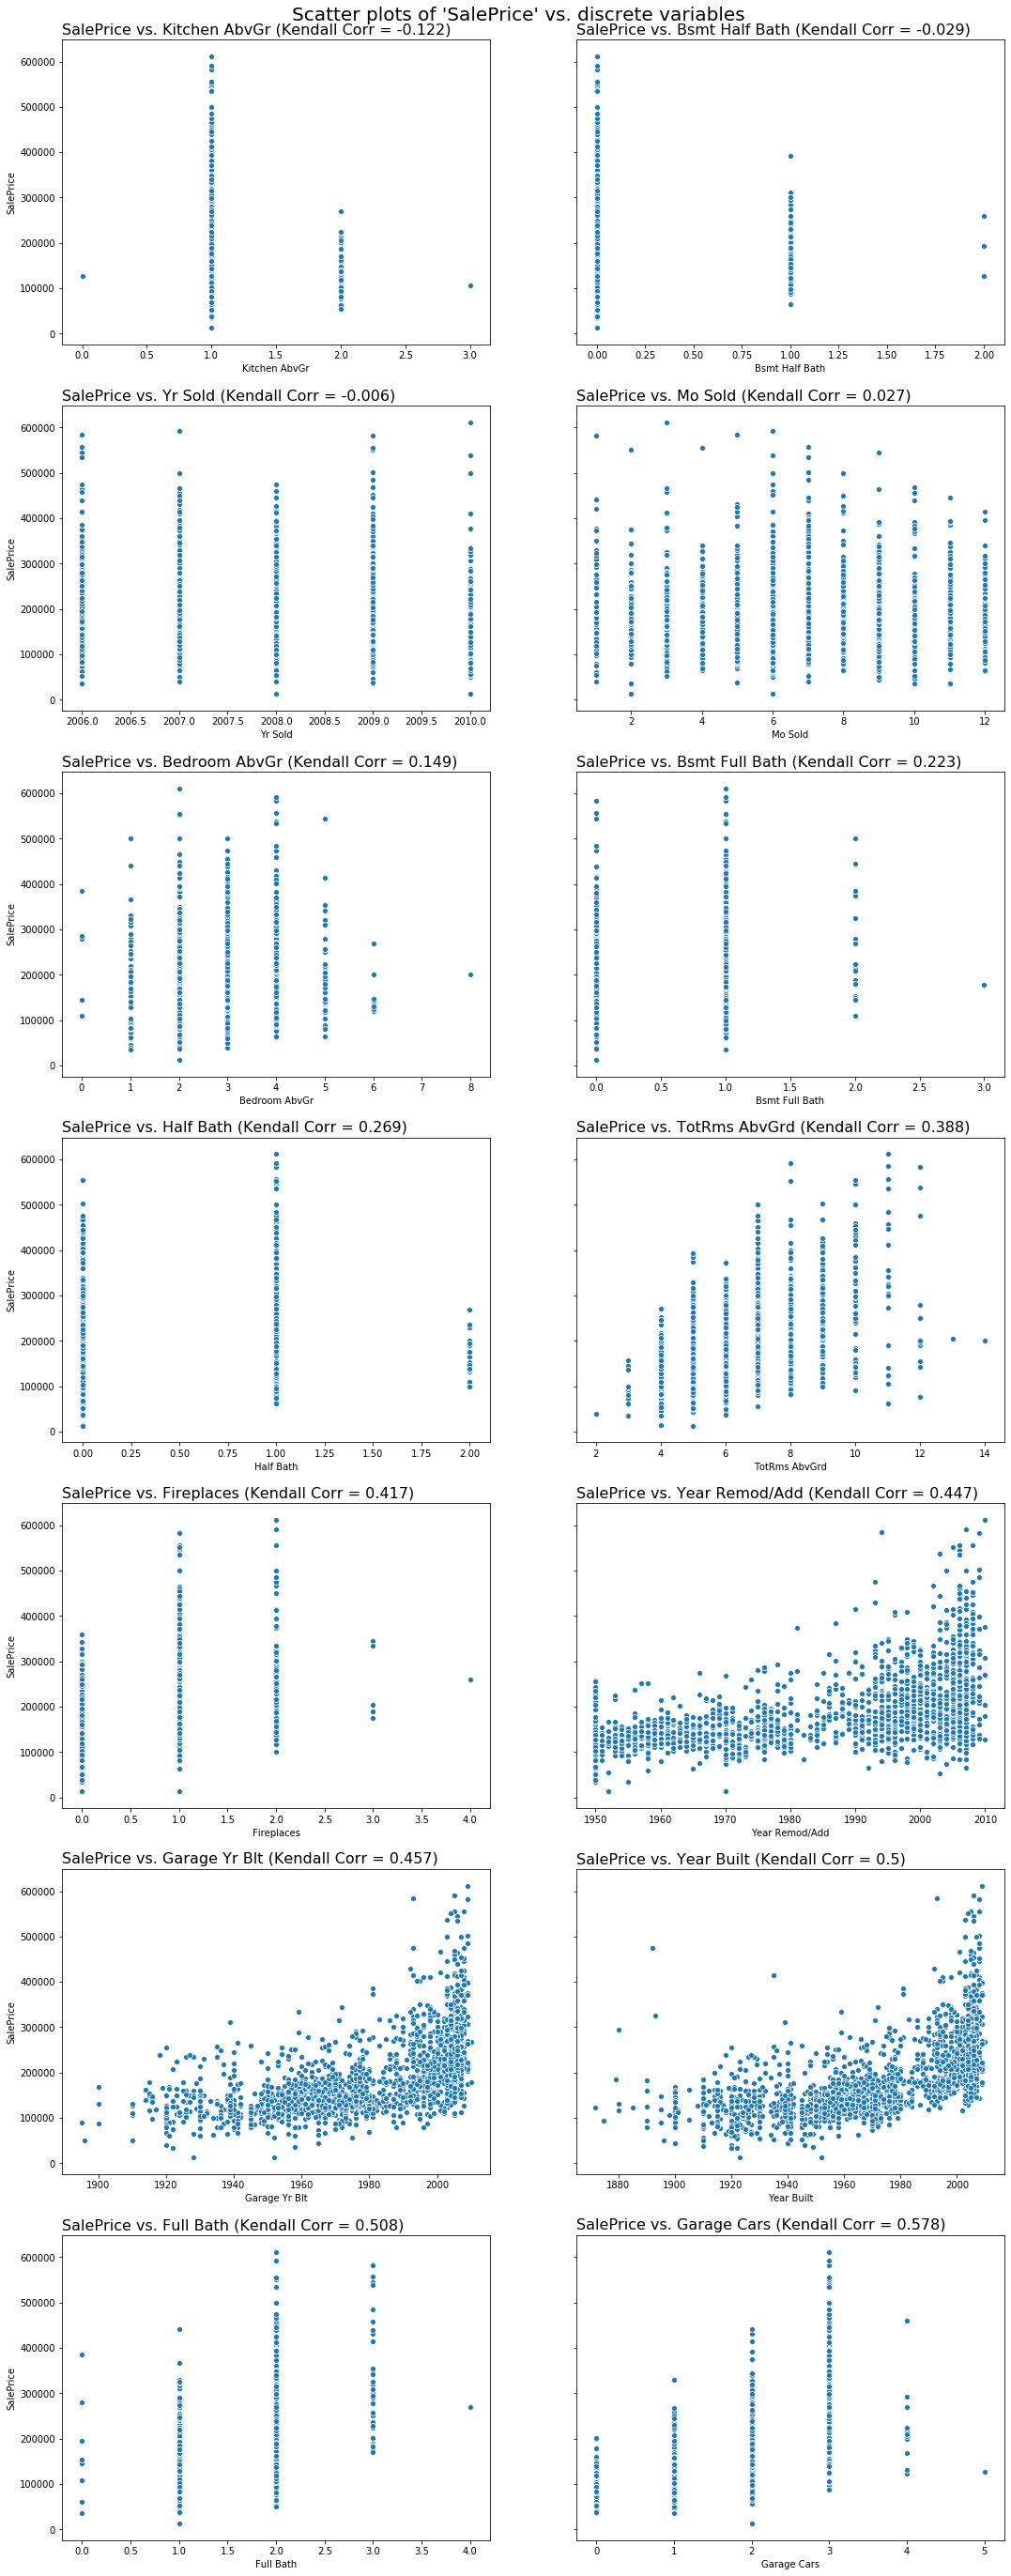

In [45]:
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(18,49), sharey=True)

ax = ax.ravel()

for i, col in enumerate(list(discrete_corr_df.columns)):
    
    sns.scatterplot(data=ce_train, x=col, y='SalePrice', ax=ax[i])
    
    kendall_coef = str(round(ce_train[['SalePrice', col]].corr(method='kendall').iloc[0,1], 3))
    
    ax[i].set_title(f"SalePrice vs. {col} (Kendall Corr = {kendall_coef})", fontsize=16, loc='left')

fig.suptitle(x=0.5, y=0.89, t="Scatter plots of 'SalePrice' vs. discrete variables", fontsize=20)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/scatterplots_discrete_variables_wo_outliers.png', bbox_inches='tight')

### EDA for Ordinal Variables

In [47]:
# Filtering all columns of ordinal variables.
# These columns will be used to calculate the correlation coefficient against 'SalePrice' column.

ordinal_corr_df = pd.DataFrame(data_dict.loc[data_dict['Variable type']=='ordinal', 'Column name'])

#Creating an extra column 'SalePrice' of 0 values. These values will be replaced with the correlation coefficient.
ordinal_corr_df['SalePrice'] = 0

# Setting 'Column name' column as index.
ordinal_corr_df.set_index('Column name', inplace=True)

# Transposing the dataframe to make indices into columns.
ordinal_corr_df = ordinal_corr_df.T

ordinal_corr_df

Column name,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,...,Electrical,Kitchen Qual,Functional,Fireplace Qu,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence
SalePrice,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


According to this [page](https://www.statisticssolutions.com/correlation-pearson-kendall-spearman/), Spearman rank correlation should be used when the variables are measured on an ordinal scale. So, I will use the **Spearman correlation method** to determine the correlation between 'SalePrice' and ordinal variables (instead of the Pearson or Kendall correlation method).

In [56]:
# Finding the Spearman correlation coefficient for all discrete variable columns.

for col in ordinal_corr_df.columns:
    spearman_coef = ce_train[['SalePrice', col]].corr(method='spearman').iloc[0,1]
    ordinal_corr_df.loc['SalePrice', col] = spearman_coef

ordinal_corr_df

Column name,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,...,Electrical,Kitchen Qual,Functional,Fireplace Qu,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence
SalePrice,-0.360464,0.036605,-0.045598,0.809084,-0.160724,0.699024,0.031576,0.699877,0.282075,0.386144,...,0.307633,0.683706,0.128762,0.54155,0.637666,0.36933,0.341743,0.350623,0.037785,-0.184658


In [57]:
# Sorting values of correlation coefficients

ordinal_corr_df.sort_values(by='SalePrice', axis=1, inplace=True)
ordinal_corr_df

Column name,Lot Shape,Fence,Overall Cond,Land Slope,Exter Cond,Utilities,Pool QC,BsmtFin Type 2,Functional,Bsmt Cond,...,Garage Qual,Bsmt Exposure,BsmtFin Type 1,Heating QC,Fireplace Qu,Garage Finish,Kitchen Qual,Exter Qual,Bsmt Qual,Overall Qual
SalePrice,-0.360464,-0.184658,-0.160724,-0.045598,0.031576,0.036605,0.037785,0.044873,0.128762,0.282075,...,0.36933,0.386144,0.415195,0.520904,0.54155,0.637666,0.683706,0.699024,0.699877,0.809084


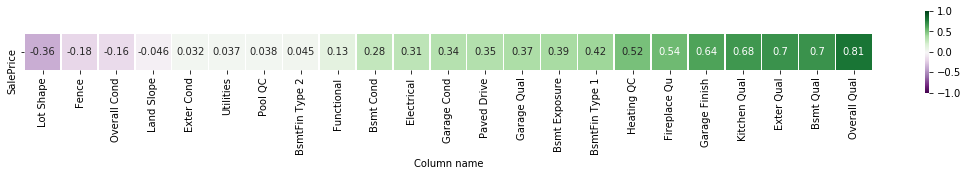

In [58]:
# Plotting the above in a heatmap to visualize the relationship.

plt.figure(figsize=(19,1.5))

sns.heatmap(ordinal_corr_df, vmin=-1, vmax=1, annot=True, square=True, linewidths=0.5, cmap='PRGn')

# Exporting plot image in PNG format.
plt.savefig('../plot_images/heatmap_ordinal_variables.png', bbox_inches='tight')

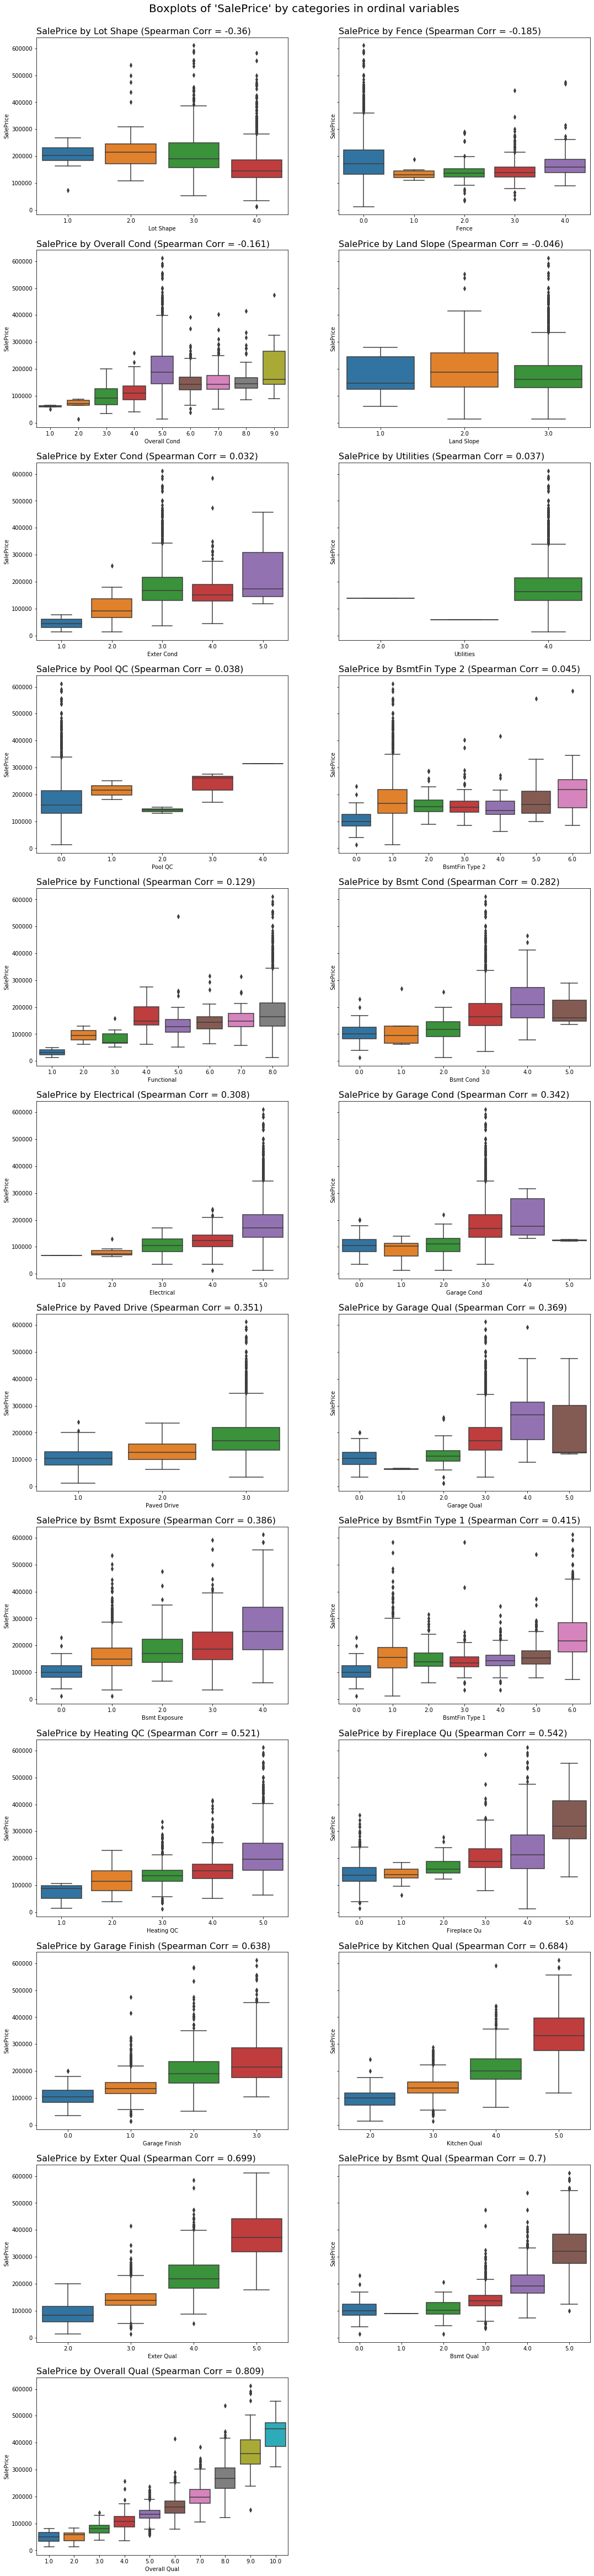

In [61]:
fig, ax = plt.subplots(nrows=12, ncols=2, figsize=(18,84), sharey=True)

ax = ax.ravel()

for i, col in enumerate(list(ordinal_corr_df.columns)):
    
    sns.boxplot(data=ce_train, x=col, y='SalePrice', ax=ax[i])
    
    spearman_coef = str(round(ce_train[['SalePrice', col]].corr(method='spearman').iloc[0,1], 3))
    
    ax[i].set_title(f"SalePrice by {col} (Spearman Corr = {spearman_coef})", fontsize=16, loc='left')

ax[23].remove()
    
fig.suptitle(x=0.5, y=0.89, t="Boxplots of 'SalePrice' by categories in ordinal variables", fontsize=20)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/boxplots_ordinal_variables.png', bbox_inches='tight')

From the above heatmap and scatter plots, we deduce the following about discrete variables:

- **Outliers**: There seems to be a presence of multiple points outside the whisker ranges in all of the boxplots above (*whis=1.5* by default). However, these points should not be termed as outliers directly, as there are a large number of such points (which means they represent the nature of the data spread in some way). So, these points do not need to be removed before proceeding.
- **Variables selected for next stage**: From the heatmap, I will select variables which have Spearman correlation coefficient of <= -0.2 & >= 0.2. So, the columns selected from this stage are: *'Lot Shape', 'Bsmt Cond', 'Electrical', 'Garage Cond', 'Paved Drive', 'Garage Qual', 'Bsmt Exposure', 'BsmtFin Type 1', 'Heating QC', 'Fireplace Qu', 'Garage Finish', 'Kitchen Qual', 'Exter Qual', 'Bsmt Qual' & 'Overall Qual'*.

In [62]:
# Filtering all selected variables for next stage.

ordinal_selected_list = list(ordinal_corr_df.T[(ordinal_corr_df.T['SalePrice'] >= 0.2) | (ordinal_corr_df.T['SalePrice'] <= -0.2)].index)
ordinal_selected_list

['Lot Shape',
 'Bsmt Cond',
 'Electrical',
 'Garage Cond',
 'Paved Drive',
 'Garage Qual',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'Heating QC',
 'Fireplace Qu',
 'Garage Finish',
 'Kitchen Qual',
 'Exter Qual',
 'Bsmt Qual',
 'Overall Qual']

### EDA for Categorical Variables

According to this [page](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9) and this [page](https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792), Pearson's R statistic calculation method (used in *df.corr()* method) is not the best correlation coefficient for categorical variables, esp. for nominal ones. Also, even though all nominal columns in the above dataframe have been one-hot encoded, we see that the number of columns in the above dataframe is >200, which is too large to be plotted in a heatmap directly. So, we will instead use Cramer's V coefficient to calculate the relationship between nominal variables, and the target variable 'SalePrice'. The code for Cramer's V has been taken from this [page](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9).

In [63]:
# Filtering all columns of nominal variables.
# These columns will be used to calculate the correlation coefficient against 'SalePrice' column.

nominal_corr_df = pd.DataFrame(data_dict.loc[data_dict['Variable type']=='nominal', 'Column name'])

#Creating an extra column 'SalePrice' of 0 values. These values will be replaced with the correlation coefficient.
nominal_corr_df['SalePrice'] = 0

# Setting 'Column name' column as index.
nominal_corr_df.set_index('Column name', inplace=True)

# Transposing the dataframe to make indices into columns.
nominal_corr_df = nominal_corr_df.T

# Dropping the 'PID' column (As explained above, 'PID' column shows parcel identification number. So, it wouldn't make logical sense to include it in the regression model.)
nominal_corr_df.drop(columns=['PID'], inplace=True)

nominal_corr_df

Column name,MS SubClass,MS Zoning,Street,Alley,Land Contour,Lot Config,Neighborhood,Condition 1,Condition 2,Bldg Type,...,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Foundation,Heating,Central Air,Garage Type,Misc Feature,Sale Type
SalePrice,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
# Function to calculate Cramer's V correlation coefficient.
# Code borrowed from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [107]:
# Filtering all columns that need one-hot encoding (all nominal columns).
# These columns will be used to calculate the Cramer's V correlation coefficient against 'SalePrice' column.

categorical_corr_df = pd.DataFrame(data_dict.loc[data_dict['Needs one-hot encoding']=='yes', 'Column name'])

#Creating an extra column 'SalePrice' of 0 values. These values will be replaced with the Cramer's V correlation coefficient.
categorical_corr_df['SalePrice'] = 0

# Setting 'Column name' column as index.
categorical_corr_df.set_index('Column name', inplace=True)

# Transposing the dataframe to make indices into columns.
categorical_corr_df = categorical_corr_df.T

categorical_corr_df

Column name,MS SubClass,MS Zoning,Street,Alley,Land Contour,Lot Config,Neighborhood,Condition 1,Condition 2,Bldg Type,...,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Foundation,Heating,Garage Type,Misc Feature,Sale Type
SalePrice,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [204]:
# Finding the Cramer's V correlation coefficient for all categorical columns.

for col in categorical_corr_df.columns:
    cramer_coef = cramers_v(c_train[col], c_train['SalePrice'])
    categorical_corr_df.loc['SalePrice', col] = cramer_coef
    
categorical_corr_df

Column name,MS SubClass,MS Zoning,Street,Alley,Land Contour,Lot Config,Neighborhood,Condition 1,Condition 2,Bldg Type,...,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Foundation,Heating,Garage Type,Misc Feature,Sale Type
SalePrice,0.177916,0.490381,0.655845,0.0751,0.249635,0.0,0.132572,0.071204,0.296134,0.0,...,0.0,0.04207,0.302921,0.0,0.249683,0.407634,0.0,0.170021,0.351669,0.270748


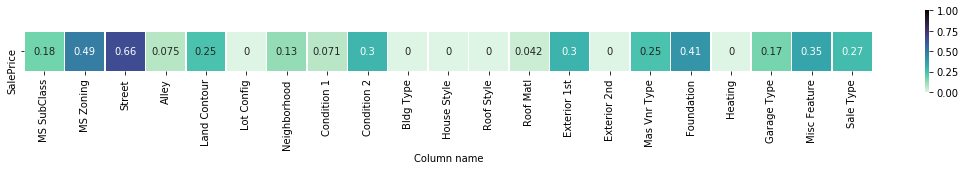

In [256]:
# Plotting the above in a heatmap to visualize the relationship.

plt.figure(figsize=(19,1.5))

sns.heatmap(categorical_corr_df, vmin=0, vmax=1, annot=True, square=True, linewidths=0.5, cmap='mako_r')

NameError: name 'categorical_corr_df' is not defined

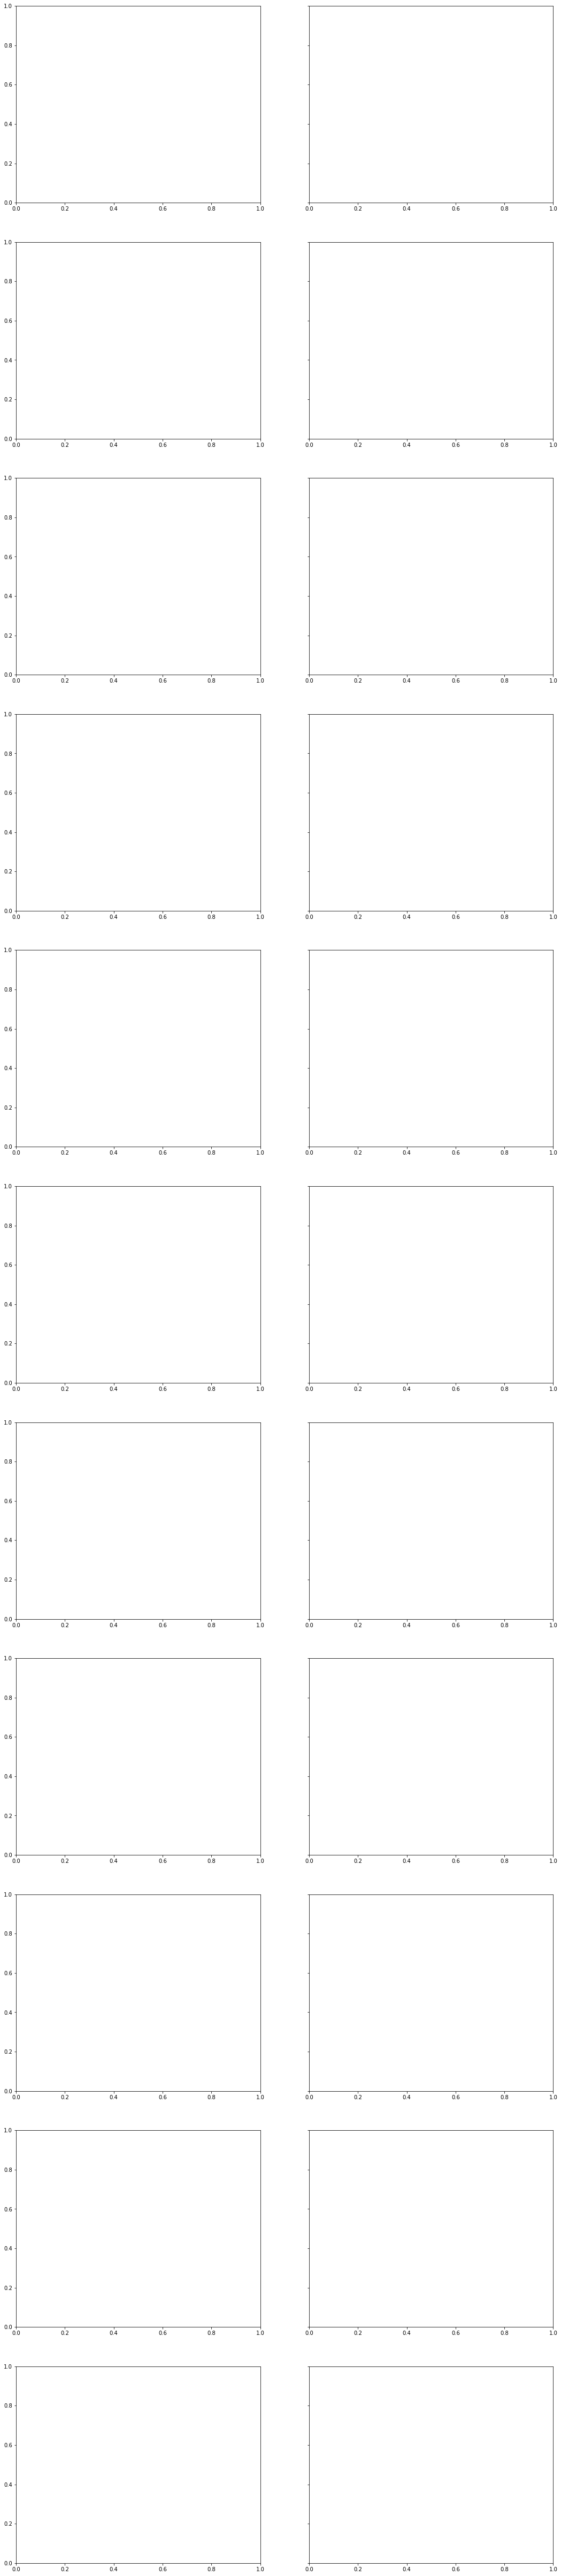

In [57]:
fig, ax = plt.subplots(nrows=11, ncols=2, figsize=(18,88), sharey=True)

ax = ax.ravel()

for i, col in enumerate(list(categorical_corr_df.columns)):
    c_train.boxplot(column='SalePrice', by=col, ax=ax[i])
    
    ax[i].set_title(col, fontsize=16, loc='left')

ax[21].remove()
fig.suptitle(x=0.5, y=0.91, t="Boxplots of 'SalePrice' by categories in nominal variables", fontsize=20);

In [ ]:
# Function to plot scatterplts as subplots
# Function takes the following arguments as input: dataframe, 
#                                                  list of column names to plot along X-axes,
#                                                  list of column names to plot along corresponding Y-axes (in the same order as above),
#                                                  list of titles for individual subplots,
#                                                  list of X-axis labels,
#                                                  list of Y-axis labels,
#                                                  boolean to share X-axis values for all subplots,
#                                                  boolean to share Y-axis values for all subplots

def subplot_scatterplots(dataframe, list_of_xcols, list_of_ycols, list_of_titles, list_of_xlabels, list_of_ylabels, sharex, sharey):
    
    # Setting number of rows of subplots according to number of columns given to plot
    nrows = int(np.ceil(len(list_of_xcols)/2))
    
    # Establishing figure and axis objects with desired number of subplot rows and columns
    # Figure size is set according to number of rows (nrows*6)
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(12,nrows*6), sharex=sharex, sharey=sharey)
    
    ax = ax.ravel()   # Ravel turns a matrix into a vector, which is easier to iterate
    
    for i, x_col in enumerate(list_of_xcols):   # Gives us an index value to get into all our lists

        # Setting colour of subplot according to position:
        # Colour for subplots in left column = 'cornflowerblue'
        # Colour for subplots in right column = 'royalblue'
        colour = ''
        if i%2==0:
            colour = 'cornflowerblue'
        else:
            colour = 'royalblue'

        # Creating scatterplot in subplot for desired X- and Y-axis columns.
        ax[i].scatter(x=dataframe[x_col], y=dataframe[list_of_ycols[i]], color=colour)
        
        # Setting title of subplot from input list of titles
        ax[i].set_title(list_of_titles[i], fontsize=16, loc='left')
        
        # Setting label for X-axis from input list of labels
        ax[i].set_xlabel(list_of_xlabels[i], fontsize=13)
        
        # Setting label for Y-axis from input list of labels
        ax[i].set_ylabel(list_of_ylabels[i], fontsize=13)

In [ ]:
# Scatterplots for Math and EBRW/Reading section scores for SAT vs. ACT in 2017 & 2018. 

# Defining lists of arguments required for the subplot_scatterplots() function defined above.
list_of_xcols = ['act17_math',
                 'act18_math',
                 'act17_reading',
                 'act18_reading'
                ]

list_of_ycols = ['sat17_math',
                 'sat18_math',
                 'sat17_ebrw',
                 'sat18_ebrw'
                ]

list_of_titles = ['2017 Math: SAT vs. ACT',
                  '2018 Math: SAT vs. ACT',
                  '2017 EBRW/Reading: SAT vs. ACT',
                  '2018 EBRW/Reading: SAT vs. ACT'
                 ]

list_of_xlabels = ['ACT 2017 Math scores',
                   'ACT 2018 Math scores',
                   'ACT 2017 Reading scores',
                   'ACT 2018 Reading scores'
                  ]

list_of_ylabels = ['SAT 2017 Math scores',
                   'SAT 2018 Math scores',
                   'SAT 2017 EBRW scores',
                   'SAT 2018 EBRW scores'
                  ]

# Calling subplot_scatterplots() function and passing in all the necessary arguments.
subplot_scatterplots(satact_1718, list_of_xcols, list_of_ycols, list_of_titles, list_of_xlabels, list_of_ylabels, sharex=True, sharey=True)

# Creating a title for the figure and establishing its position and size.
plt.suptitle(x=0.5, y=0.94, t='Average scaled scores for SAT* vs. ACT^ in 2017 & 2018', fontsize=20)

# Creating a note about X-axis units and establishing its position and size.
plt.figtext(x=0.08, y=0.05, s="* SAT possible range of scores: 200 - 800 (inclusive)\n^ ACT possible range of scores: 1 - 36 (inclusive)", fontsize=13);

# Exporting plot image in PNG format.
plt.savefig('../plot_images/scatter_plot_1.png')

In [30]:
p_corr = ce_train.corr()

for i in p_corr.index:
    for j in p_corr.columns:
        if -0.2 < p_corr[i][j] < 0.2:
            p_corr[i][j]=0

In [31]:
len(p_corr[p_corr['SalePrice']!=0]['SalePrice'])-1

62

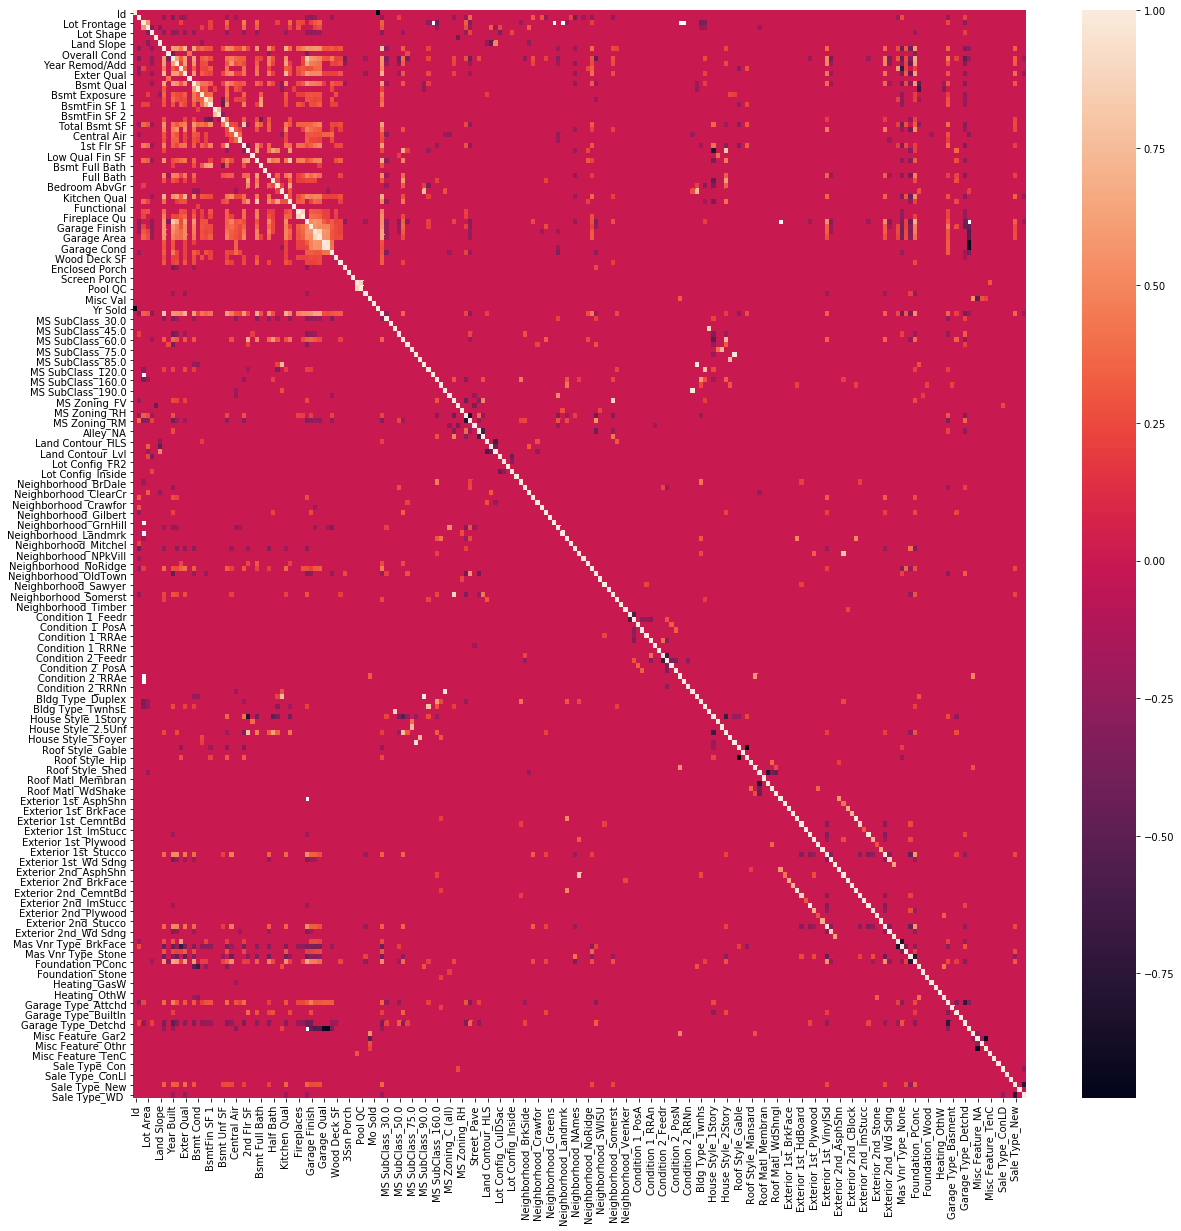

In [32]:
plt.figure(figsize=(20,20))

sns.heatmap(p_corr)

In [218]:
mylist = [col for col in ce_train.columns if 'Lot Config' in col]

In [220]:
mylist.append('SalePrice')

In [223]:
ce_train[mylist].corr()['SalePrice']

Lot Config_Corner    -0.004879
Lot Config_CulDSac    0.162922
Lot Config_FR2       -0.014678
Lot Config_FR3        0.025429
Lot Config_Inside    -0.084031
SalePrice             1.000000
Name: SalePrice, dtype: float64

In [224]:
mylist_street = [col for col in ce_train.columns if 'Street' in col]

In [225]:
mylist_street.append('SalePrice')

In [226]:
ce_train[mylist_street].corr()['SalePrice']

Street_Grvl   -0.069882
Street_Pave    0.069882
SalePrice      1.000000
Name: SalePrice, dtype: float64



Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

In [12]:
features = ['Utilities', 'Year Built']

In [13]:
X = ce_train[features]
y = ce_train['SalePrice']

In [15]:
X.shape

(2044, 2)

In [16]:
y.shape

(2044,)

In [14]:
lm = LinearRegression()

In [17]:
lm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
lm.predict(X)

array([187895.73640563, 217944.65306677, 153339.48224532, ...,
       115778.3364189 , 157846.81974449, 222451.99056594])

In [19]:
lm.score(X, y)

0.32726030597061806

In [20]:
X_test = ce_test[features]

In [21]:
pred = lm.predict(X_test)

In [22]:
pred

array([ 88734.31142387, 189398.18223869, 232969.11139734, 108266.10725361,
       168363.94057589, 181885.9530734 , 160851.71141061, 189398.18223869,
       229964.21973123, 189398.18223869, 210432.42390149, 111270.99891972,
       154841.92807838, 223954.436399  , 109768.55308667, 159349.26557755,
       133807.68641558, 157846.81974449, 165359.04890978,  46665.82809827,
       175876.16974118, 165359.04890978, 213437.3155676 , 177378.61557423,
       234471.5572304 , 181885.9530734 , 103758.76975444,  43660.93643216,
       168363.94057589, 141319.91558086, 180383.50724035, 111270.99891972,
        43660.93643216, 183388.39890646, 225456.88223206, 232969.11139734,
       103758.76975444, 141319.91558086, 153339.48224532, 222451.99056594,
       237476.44889651, 220949.54473289, 162354.15724366, 150334.59057921,
       204422.64056926, 178881.06140729, 225456.88223206, 171368.832242  ,
       157846.81974449, 168363.94057589, 118783.22808501,  58685.39476273,
       234471.5572304 , 1

In [26]:
submission = pd.DataFrame(pred, columns=['SalePrice'])

In [40]:
sub = ce_test[['Id']].sort_values(by='Id').astype(int)

In [42]:
sub['SalePrice'] = pred

In [43]:
sub

,Id,SalePrice
704,2,88734.311424
706,4,189398.182239
120,6,232969.111397
312,7,108266.107254
401,17,168363.940576
...,...,...
537,2919,184890.844740
179,2921,172871.278075
829,2922,175876.169741
669,2925,180383.507240


In [44]:
sub.to_csv('../datasets/submission_0.csv', index=False)

Automatically created module for IPython interactive environment
Optimal number of features : 3


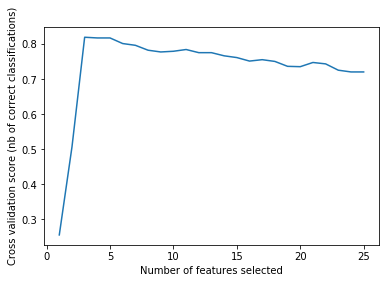

In [18]:
print(__doc__)

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000, n_features=25, n_informative=3,
                           n_redundant=2, n_repeated=0, n_classes=8,
                           n_clusters_per_class=1, random_state=0)

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()